In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import copy

In [2]:
#read in and clean data
stations = pd.read_csv("stations.csv", delimiter = ',', nrows = None, na_values=['', 'N/A', 'CA'])

#set up for new variables & station dictionary
station_list = []
station_dict = {}
station_index = []
lat_list = []
lon_list = []
yr_mo = []
months = []
intro_months = []
groups = []

group_to_station = dict(zip(range(9), [
                                    [0, 1],
                                    [2, 15, 22, 23],
                                    [3, 4], 
                                    [5, 6, 7, 8, 9, 10], 
                                    [11, 12, 13], 
                                    [14, 16, 20],
                                    [17],
                                    [18, 21],
                                    [19, 24, 25, 26]]))
station_to_group = {}
for k,l in group_to_station.items():
    for v in l:
        station_to_group[v] = k

for i, row in stations.iterrows():
    #when encountering a new station
    if row['Station Name'] not in station_dict.keys():
        #get number of station for ID and add to list of stations
        val = len(station_list)
        station_list.append(val)
        #store station info in dictionary
        station_dict[row['Station Name']] = (val, row['Address 1'], row['Start Date'], (row['Year'], row['Month'], row['Day']))
        intro_months.append((row['Year'], row['Month']))
    else:
        val = station_dict[row['Station Name']][0]
    if (row['Year'], row['Month']) not in months:
        months.append((row['Year'], row['Month']))
    station_index.append(val)
    groups.append(station_to_group[val])
    yr_mo.append((row['Year'], row['Month']))

stations['ID'] = station_index
stations["Starting"] = pd.to_datetime(stations["Start Date"])
stations["Year Month"] = yr_mo
stations["Station Group"] = groups

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
stations.to_csv('check.csv')

In [4]:
# helper functions

''' 
A function that converts a date in the format given by data into a datetime object
:param d: - a date as a string (assuming uniform formatting)
:return: the date as a Date namedtuple
'''
def convert_date(d):
    # considering format 'dd/mm/yyyy hh:mm'
    date = d.split(' ')[0].split('/')
    time = d.split(' ')[1].split(':')
    return datetime.datetime(int(date[2]), int(date[1]), int(date[0]), int(time[0]), int(time[1]))

'''
A function that calculates the difference between two datetime objects, in minutes
:param earlier: datetime object representing earlier of the two times
:param later: datetime object representing later of the two times
:return: the difference in the two times, in minutes
'''
def calc_time_diff(earlier,later):
    delta = later - earlier
    return delta.days*1440.0 + delta.seconds/60.0

'''
A function that returns a list of interarrival times from data
:param data: a list of times at which cars arrived at a charging station
:param peak_list: a list with entry 1 if corresponding hour is a peak hour, 0 o.w.
:return: the interarrival times given by the input data
'''
def interarrival_calc(data, peak_map):
    peak_durs = []
    non_peak_durs = []
    pairs = list(zip(data[0:-1],data[1:]))
    for p in pairs:
        diff = calc_time_diff(p[0],p[1])
        if peak_map[p[0].hour] and peak_map[p[1].hour]: 
            peak_durs.append(diff)
        else: 
            non_peak_durs.append(diff)
    return peak_durs, non_peak_durs

In [5]:
uniq_stations = set(stations["Station Name"])
num_stations = len(uniq_stations)
num_groups = len(group_to_station.keys())
name_to_id = dict(zip(list(uniq_stations),range(num_stations)))
id_to_name = dict(zip(range(num_stations), list(uniq_stations)))
station_ids = np.zeros(stations.shape[0], dtype=np.int8)
month_year = []
start_dates = []

for i,row in stations.iterrows():
    month_year.append((row["Year"], row["Month"]))
    sd = row["Start Date"]
    if sd.find("/20"):
        sd = sd.replace("/20", "/")
    start_dates.append(convert_date(sd))
    
stations["Month/Year"] = month_year
stations["Start Date (dt)"] = start_dates

dates = list(set(stations["Month/Year"]))
num_months = len(set(stations["Month/Year"]))

In [6]:
# calculate probability of arrival for each station in each hour
distribution_matrix = np.zeros((num_stations, 24))
get_hour = lambda d: d.hour

for i in range(num_groups):
    inds = group_to_station[i]
    group_data = stations.loc[stations["Station Group"] == i]
    hour_data = group_data["Start Date (dt)"].apply(get_hour)
    freq = group_data.shape[0]
    for h in range(24):
        distribution_matrix[inds,h] = np.sum(hour_data == h)
    distribution_matrix[inds] = distribution_matrix[inds]/freq

# learn optimal separation between peak and non-peak hours
kmeans = KMeans(2, random_state=69).fit(distribution_matrix.T)
peak_mapping = kmeans.predict(distribution_matrix.T) # 1 indicates peak time, 0 indicates non-peak

In [7]:
sorted_dates = sorted(dates,key=(lambda d: (d[0],d[1])))
rate_params_peak = np.full((num_stations,num_months), -1.0)
rate_params_nonpeak = np.full((num_stations,num_months), -1.0)

calc_beta = lambda d: np.median(d) if len(d) > 0 else -1

stns_by_mo = np.zeros((num_groups,len(sorted_dates)),dtype=np.int8)
existing_stns = {}

for i,date in enumerate(sorted_dates):
    month_data = stations.loc[stations["Month/Year"] == date]
    existing_stns[date] = {}
    for g in range(num_groups):
        num_stns = 0
        grp_data = month_data.loc[month_data["Station Group"] == g]
        stn_list = []
        for stn in group_to_station[g]:
            if np.sum(grp_data["ID"] == stn) > 0:
                num_stns += 1
                stn_list.append(stn)   
            stns_by_mo[g,i] = num_stns
            
            times = list(grp_data["Start Date (dt)"])
            peak, non_peak = interarrival_calc(times, peak_mapping)
            rate_params_peak[stn_list,i] = calc_beta(np.array(peak))
            rate_params_nonpeak[stn_list,i] = calc_beta(np.array(non_peak))
        existing_stns[date][g] = stn_list   

# rate_params_peakold = np.full((num_stations,num_months), -1.0)
# rate_params_nonpeakold = np.full((num_stations,num_months), -1.0)
# for i in range(num_stations): # iterating over stations
#     # isolating samples associated with specific station
#     station_data = stations.loc[stations["ID"] == i] 
#     for j,date in enumerate(sorted_dates): # iterating over months
#         station_data_month = station_data.loc[stations["Month/Year"] == date]
#         if station_data_month.shape[0] > 0: 
#             times = list(station_data_month["Start Date (dt)"])
#             peak, non_peak = interarrival_calc(times, peak_mapping)
#             rate_params_peakold[i,j] = calc_beta(np.array(peak))
#             rate_params_nonpeakold[i,j] = calc_beta(np.array(non_peak))

In [8]:
#mean park duration by station, peak/not peak
peak_params = np.zeros(num_groups)
nonpeak_params = np.zeros(num_groups)
for g in range(num_groups):
#     inds = group_to_station[g]
    stations_17 = stations.loc[stations["Year"] == 2017]
    peak_times = stations_17.loc[stations["Station Group"] == g]
    peak_times = peak_times.loc[peak_mapping[peak_times["Hour"]] == 1]["Park Duration"]
    nonpeak_times = stations_17.loc[stations["Station Group"] == g]
    nonpeak_times = nonpeak_times.loc[peak_mapping[nonpeak_times["Hour"]] == 0]["Park Duration"]
    peak_params[g] = np.mean(peak_times)
    nonpeak_params[g] = np.mean(nonpeak_times)
    
print(peak_params)
print(nonpeak_params)

[ 154.49765651  151.02868818  142.5247366   147.46405857  140.50037546
  182.12134576  185.59324757  158.66560962  150.80653061]
[ 261.32763052  173.86007605  422.10607595  341.37040094  375.78651475
  308.38278481  373.45163265  203.67614973  316.58354167]


In [9]:
#set up params for simulation -- includes some default
sim_months_17 = [(2016, 8), (2016, 9), (2016, 10), (2016, 11), (2016, 12), (2017, 1), (2017, 2), (2017, 3),
             (2017, 4), (2017, 5), (2017, 6), (2017, 7)]
sim_months_18 = [(2017, 8), (2017, 9), (2017, 10), (2017, 11), (2017, 12), (2018, 1), (2018, 2), (2018, 3),
             (2018, 4), (2018, 5), (2018, 6), (2018, 7)]
for_rate = [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

LAST_MONTH = (2017, 7)

#minutes in each month
month_minutes = [44640, 40320, 44640, 43200, 44640, 43200, 44640, 44640, 43200, 44640, 43200, 44640]

# get lambdas for 2018
rate_params_peak18 = np.full((num_stations,num_months), -1.0)
rate_params_nonpeak18 = np.full((num_stations,num_months), -1.0)

for station in range(num_stations):
    for r in for_rate:
        rate_params_peak18[station,r] = rate_params_peak[station,-1]
        rate_params_nonpeak18[station,r] = rate_params_nonpeak[station,-1]

In [10]:
def simulate(sim_months = sim_months_18, month_minutes = month_minutes, rate_index = for_rate, num_stations = 27,
            capped = False, cap = 120, sensitivity = 0, num_missing = 0,
            rate_params_peak = rate_params_peak18, rate_params_nonpeak = rate_params_nonpeak18, 
             peak_params = peak_params, nonpeak_parms = nonpeak_params, existing_stns = existing_stns):
    #ensure seed is the same every time
    np.random.seed(1660)
    N = num_groups # changed for grouping
    
    #to be returned
    visits = np.zeros((N, len(sim_months)))
    
    #generate results for each month
    for m in range(len(sim_months)):
        durations = {}
        
        if sim_months[m] in sim_months_18:
            existing_stns[sim_months[m]] = existing_stns[LAST_MONTH]
            if num_missing > 0:
                num_ports = stns_by_mo[:,-1]*2
                num_ports[8] = num_ports[8] - (num_missing*2)
            else:
                num_ports = stns_by_mo[:,-1]*2
        else:
            num_ports = stns_by_mo[:,for_rate[m]]*2

        for i in range(N):
            durations[i] = np.zeros(num_ports[i], dtype=np.float32)
        time = np.zeros(N)
        empty = copy.copy(num_ports)
        #while the current time is under the amount of time in the month for any station
        while any(time < month_minutes[sim_months[m][1] - 1]):
            #generate visits station by station so at about same time at all stations 
            for g in range(N):
                if sim_months in sim_months_18:
                    if num_missing > 0:
                        active_stns = float(stns_by_mo[g][-1]) - num_missing
                    else:
                        active_stns = float(stns_by_mo[g][-1])
                else:
                    active_stns = float(stns_by_mo[g][for_rate[m]])
                if time[g] < month_minutes[sim_months[m][1] - 1]:
                #get rate parameter for this station in this month
                    if active_stns > 0:
                        # arbitrary station associated with the group
                        #s = existing_stns[sim_months[m]][g][0]
                        s = np.random.choice(group_to_station[g])
                        if np.mod(time[g], 1440) < 360 or np.mod(time[g], 1440) > 1260:
                            lam = rate_params_nonpeak[s,for_rate[m]] #/active_stns
                        else:
                            lam = rate_params_peak[s,for_rate[m]] #/active_stns
                            
                        if lam > 0:
                            p = np.random.exponential(lam)
                        #indicates no arrivals at either peak or non peak - set to next arrival session
                        else: 
                            if np.mod(time[g], 1440) < 360:
                                p = 360 - np.mod(time[g], 1440)
                            elif np.mod(time[g], 1440) > 1260:
                                p = 360 + (1440 - np.mod(time[g], 1440))
                            else:
                                p = 1260 - np.mod(time[g], 1440)
                        
                time[g] += p
                        
                #check if enough time has passed that a spot opened 
                
                emptied = np.where(time[g] > durations[g])[0]
                num_emptied = 0
                for ind in emptied:
                    if durations[g][ind] != 0:
                        num_emptied += 1
                        durations[g][ind] = 0   
                empty[g] += num_emptied
                
                if empty[g] > 0 and time[g] < month_minutes[sim_months[m][1] - 1]:
                    if np.mod(time[g], 1440) < 360 or np.mod(time[g], 1440) > 1260:
                        park_dur = np.random.exponential(nonpeak_params[g])
                    else:
                        park_dur = np.random.exponential(peak_params[g])
                        if capped and park_dur > cap:
                            park_dur = cap
                            if np.random.uniform() < sensitivity:
                                park_dur = 0
                                
                    empty_ind = np.where(durations[g] == 0)[0]
                    if park_dur > 0 and empty_ind != []:
                        empty[g] -= 1
                        visits[g][m] += 1
                        durations[g][empty_ind[0]] = park_dur + time[g]
                    
    return visits 

In [11]:
#RUN SIMULATIONS
        
#true data for comparison
visits_2017 = np.zeros((num_groups, len(sim_months_17)))
for m in range(len(sim_months_17)):
    month = stations[stations["Year Month"]==sim_months_17[m]]
    month_counts =  month.groupby("Station Group").count()
    month_counts = month_counts.iloc[:,[0]]
    month_counts.columns = ["Monthly Visits"]
    for i, row in month_counts.iterrows():
        visits_2017[i][m] = row["Monthly Visits"]

#simulations
visits_2017_simulated = simulate(sim_months = sim_months_17, rate_params_peak = rate_params_peak, rate_params_nonpeak = rate_params_nonpeak)
visits_2018 = simulate(sim_months = sim_months_18)
#CHANGE RIGHT HERE 
visits_2hr_sense0 = simulate(capped = True, sensitivity = .0)
visits_2hr_sense25 = simulate(capped = True, sensitivity = .25)
visits_2hr_sense5 = simulate(capped = True, sensitivity = .5)
visits_3hr_sense0 = simulate(capped = True, cap = 180, sensitivity = 0)
visits_3hr_sense25 = simulate(capped = True, cap = 180, sensitivity = .25)
visits_3hr_sense5 = simulate(capped = True, cap = 180, sensitivity = .5)
visits_1missing = simulate(num_missing = 1)
visits_2missing = simulate(num_missing = 2)
visits_3missing = simulate(num_missing = 3)

print(visits_2017)
print(visits_2017_simulated)
print(visits_2018)
print(visits_2hr_sense0)
print(visits_1missing)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


[[  504.   492.   499.   462.   459.   464.   425.   487.   438.   488.
    481.   453.]
 [  466.   382.   470.   424.   384.   774.   819.   961.   883.  1015.
   1036.   942.]
 [  355.   312.   383.   355.   330.   353.   353.   393.   308.   302.
    312.   282.]
 [  616.   626.   709.   701.   563.   657.   619.   705.   628.   740.
    602.   605.]
 [  491.   450.   473.   440.   438.   449.   433.   515.   492.   524.
    484.   459.]
 [  923.   859.   874.   831.   788.   804.   760.   897.   825.   900.
    874.   752.]
 [  273.   284.   281.   235.   256.   257.   245.   283.   261.   301.
    279.   270.]
 [  565.   542.   600.   540.   512.   562.   532.   568.   557.   585.
    573.   532.]
 [  164.   144.   168.   153.   141.   176.    99.    12.   124.   160.
    138.   662.]]
[[  436.   413.   441.   433.   406.   419.   318.   433.   440.   427.
    431.   413.]
 [  158.   143.   158.   164.   151.   923.   752.  1052.  1131.  1123.
   1144.  1085.]
 [  357.   309.   34

In [12]:
#to make summary results

results = [visits_2017, visits_2017_simulated, visits_2018, visits_2hr_sense0, visits_2hr_sense25, visits_2hr_sense5, 
           visits_3hr_sense0, visits_3hr_sense25, visits_3hr_sense5, visits_1missing, visits_2missing, visits_3missing]

totals = np.zeros((len(results), 12))
for r in range(len(results)):
    months = np.sum(results[r], axis = 0)
    totals[r] = months
np.savetxt('totals.csv', totals.T, delimiter = ',', header = 'Real 2017, Simulated 2017, Simulated 2018, Cap 2 (0), Cap 2 (.25), Cap 2 (.5), Cap 3 (0), Cap 3 (.25), Cap 3 (.5), Missing 1, Missing 2, Missing 3')

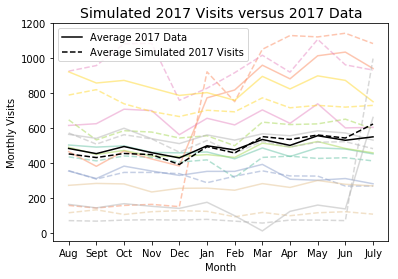

In [13]:
#PLOTTING 2017 VERSUS 2017 SIMULATED
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

N = num_groups
y = range(12)
fig = plt.figure()

custom_lines = [Line2D([0], [0], color='black', linestyle = 'solid', lw=1.5),
                Line2D([0], [0], color='black', linestyle = 'dashed', lw=1.5)] 
viridis = cm.get_cmap("Set2", N)
for r in range(N):
    plt.plot(y, visits_2017[r] , color = viridis.colors[r], label = '2017', linestyle='solid', markersize = 3, alpha = .5)
    plt.plot(y, visits_2017_simulated[r], color = viridis.colors[r], label = '2018',linestyle='dashed', markersize = 3, alpha = .5)
plt.plot(y, np.mean(visits_2017, axis = 0) , color = 'black', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2017_simulated, axis = 0), color = 'black', label = '2018', linestyle='dashed',  markersize = 3, alpha = 1)
plt.xticks(y, ('Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', "Mar", "Apr", "May", "Jun", "July"),  
           rotation='horizontal', color = 'black')
plt.ylabel('Monthly Visits')
plt.xlabel('Month')
plt.title("Simulated 2017 Visits versus 2017 Data", fontsize=14, color = "black")
plt.legend(custom_lines, ['Average 2017 Data', 'Average Simulated 2017 Visits'])
plt.savefig('2017 v 2017 sim.png', transparent=True)
plt.show()


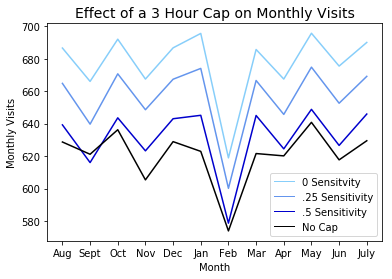

In [14]:
#PLOT 2018 DATA WITH 3 HOURS CAP AT ALL SENSITIVITY

y = range(12)
N = num_groups
custom_lines = [Line2D([0], [0], color='lightskyblue', linestyle = 'solid', lw=1),
                Line2D([0], [0], color='cornflowerblue', linestyle = 'solid', lw=1), 
               Line2D([0], [0], color='mediumblue', linestyle = 'solid', lw=1),
               Line2D([0], [0], color='black', linestyle = 'solid', lw=1)]

plt.plot(y, np.mean(visits_3hr_sense0, axis = 0) , color = 'lightskyblue', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_3hr_sense25, axis = 0), color = 'cornflowerblue', label = '2018', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_3hr_sense5, axis = 0) , color = 'mediumblue', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2018, axis = 0) , color = 'black', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.xticks(y, ('Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', "Mar", "Apr", "May", "Jun", "July"),  
           rotation='horizontal', color = 'black')
plt.ylabel('Monthly Visits')
plt.xlabel('Month')
plt.title("Effect of a 3 Hour Cap on Monthly Visits", size = 14, color = "black")
plt.legend(custom_lines, ['0 Sensitvity', '.25 Sensitivity', '.5 Sensitivity', 'No Cap'])
plt.savefig('3hourCap', transparent=True)
plt.show()




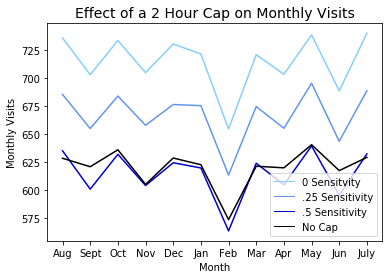

In [15]:
#PLOT 2018 DATA WITH 2 HOURS CAP AT ALL SENSITIVITY
custom_lines = [Line2D([0], [0], color='lightskyblue', linestyle = 'solid', lw=1),
                Line2D([0], [0], color='cornflowerblue', linestyle = 'solid', lw=1), 
               Line2D([0], [0], color='mediumblue', linestyle = 'solid', lw=1),
               Line2D([0], [0], color='black', linestyle = 'solid', lw=1)]

viridis = cm.get_cmap("Set1", 27)
plt.plot(y, np.mean(visits_2hr_sense0, axis = 0) , color = 'lightskyblue', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2hr_sense25, axis = 0), color = 'cornflowerblue', label = '2018', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2hr_sense5, axis = 0) , color = 'mediumblue', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2018, axis = 0) , color = 'black', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.xticks(y, ('Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', "Mar", "Apr", "May", "Jun", "July"),  
           rotation='horizontal', color = 'black')
plt.ylabel('Monthly Visits')
plt.xlabel('Month')
plt.title("Effect of a 2 Hour Cap on Monthly Visits", size = 14, color = "black")
plt.legend(custom_lines, ['0 Sensitvity', '.25 Sensitivity', '.5 Sensitivity', 'No Cap'], loc = 'lower right')
plt.savefig('2hourCap', transparent=True)
plt.show()




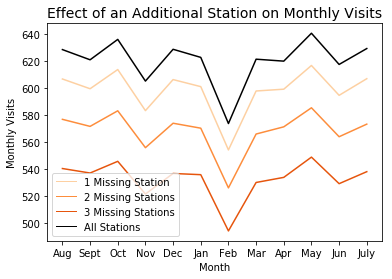

In [16]:
#Plotting Impact of adding new stations

custom_lines = [Line2D([0], [0], color=plt.cm.tab20c(7), linestyle = 'solid', lw=1),
                Line2D([0], [0], color=plt.cm.tab20c(5), linestyle = 'solid', lw=1), 
               Line2D([0], [0], color=plt.cm.tab20c(4), linestyle = 'solid', lw=1),
               Line2D([0], [0], color='black', linestyle = 'solid', lw=1)]


        
viridis = cm.get_cmap("Set1", N)
plt.plot(y, np.mean(visits_1missing, axis = 0) , color = plt.cm.tab20c(7), label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2missing, axis = 0), color = plt.cm.tab20c(5), label = '2018', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_3missing, axis = 0) , color = plt.cm.tab20c(4), label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.plot(y, np.mean(visits_2018, axis = 0) , color = 'black', label = '2017', linestyle='solid',  markersize = 3, alpha = 1)
plt.xticks(y, ('Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', "Mar", "Apr", "May", "Jun", "July"),  
           rotation='horizontal', color = 'black')
plt.ylabel('Monthly Visits')
plt.xlabel('Month')
plt.title("Effect of an Additional Station on Monthly Visits", fontsize = 14, color = "black")
plt.legend(custom_lines, [ '1 Missing Station', '2 Missing Stations', '3 Missing Stations', 'All Stations'])

plt.savefig('AdditionalStations', transparent=True)
plt.show()


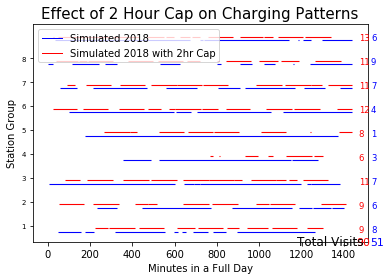

In [17]:
#Plotting the duration of park times with and without cap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D             

#initlize dimensions and plot properties
x = 1440
y = N

fig, ax = plt.subplots()
ax.plot(x, y)

custom_lines = [Line2D([0], [0], color='blue', linestyle = 'solid', lw=1),
                Line2D([0], [0], color='red', linestyle = 'solid', lw=1)]
plt.ylabel('Station Group')
plt.xlabel('Minutes in a Full Day')
plt.title("Effect of 2 Hour Cap on Charging Patterns", fontsize = 15, color = "black")
plt.legend(custom_lines, [ 'Simulated 2018', 'Simulated 2018 with 2hr Cap'])
stat_label = np.arange(0, N, 1)
plt.yticks(range(0,len(stat_label)) ,stat_label, size = 7)

#create lists of duration for empty and parked time for both capped and non capped situations 
#using the lambda parameters we learned for in previous code

#set empty structures. 2 = capped data 
empty = [[] for x in range(N)]
full = [[] for x in range(N)]

empty2 = [[] for x in range(N)]
full2 = [[] for x in range(N)]
tot_vis = 0
tot_vis2 = 0

#iterate over each group of stations 
for s in range(N):
    time = 0
    #while the day is not over
    while time < 1440:
        park_dur =0
        if np.mod(time, 1440) < 360 or np.mod(time, 1440) > 1260:
            lam = rate_params_nonpeak18[s,for_rate[m]]
        else:
            lam = rate_params_peak18[s,for_rate[m]]
        p = np.random.exponential(lam)
        time += p
        empty[s].append(p)
        if np.mod(time, 1440) < 360 or np.mod(time, 1440) > 1260:
            park_dur = np.random.exponential(nonpeak_params[s])
        else:
            park_dur = np.random.exponential(peak_params[s])
        if park_dur + time > 1440:
            park_dur = 1440 - time
        if time < 1440:
            ax.hlines(y=(.75 + s), xmin=time, xmax=time + park_dur, linewidth=1.1, color='blue')
            time += park_dur
            full[s].append(park_dur)
        x = len(full[s])
    ax.text(1528, (.75 + s),  str(x),  color='blue', rotation = 0, size =8.5)
    tot_vis += x
    time2 = 0
      
    while time2 < 1440:
        if np.mod(time2, 1440) < 360 or np.mod(time2, 1440) > 1260:
            lam = rate_params_nonpeak18[s,for_rate[m]]
        else:
            lam = rate_params_peak18[s,for_rate[m]]
        p = np.random.exponential(lam)
        time2 += p
        empty2[s].append(p)
        if np.mod(time2, 1440) < 360 or np.mod(time2, 1440) > 1260:
            park_dur = np.random.exponential(nonpeak_params[s])
        else:
            park_dur = np.random.exponential(peak_params[s])
        if park_dur > 120:
            park_dur = 120
        if park_dur + time2 > 1440:
            park_dur = 1440 - time2
        if time2 <1440:
            ax.hlines(y=(.9 + s), xmin=time2, xmax=time2 + park_dur, linewidth=1.1, color='r')
            time2 += park_dur
            full2[s].append(park_dur)
        x = len(full2[s])
    ax.text(1470, (.75 + s),  str(x),  color='red', rotation = 0, size =8.5)
    tot_vis2 += x
tot_visS = str(tot_vis)
tot_vis2S = str(tot_vis2)
ax.text(1458, (0.2),  str(tot_vis2S),  color='red', rotation = 0, size =11)    
ax.text(1525, (0.2),  str(tot_visS),  color='blue', rotation = 0, size =11)
ax.text(1180, (0.2),  'Total Visits',  color='black', rotation = 0, size =12)
    #ax.plot((.5 + s, 1, 1), label = '4')
plt.savefig('2hourCapLineGraph',face_color ='w', transparent=True)
plt.show()


[ 0.14308125  0.13724373  0.14051509  0.15333191  0.1487831   0.14467878
  0.14378648  0.15166013  0.13909858  0.1503879   0.15184683  0.14537979] [ 0.88801245  0.89255036  0.89000681  0.88005371  0.88358387  0.88677126
  0.88746448  0.88135082  0.89110803  0.88233815  0.88120594  0.88622672]


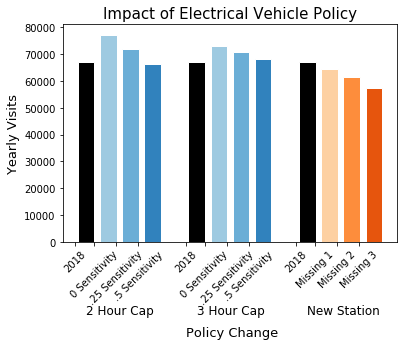

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats

y = 1

miss1_t, miss1_p = scipy.stats.ttest_ind(visits_2018, visits_1missing)
print(miss1_t, miss1_p)

#set height of bars
bar2018 = np.sum(visits_2018)
bar1miss = np.sum(visits_1missing)
bar2miss = np.sum(visits_2missing)
bar3miss = np.sum(visits_3missing)
bar2hr0 = np.sum(visits_2hr_sense0)
bar2hr25 = np.sum(visits_2hr_sense25)
bar2hr5 = np.sum(visits_2hr_sense5)
bar3hr25 = np.sum(visits_3hr_sense25)
bar3hr0 = np.sum(visits_3hr_sense0)
bar3hr5 = np.sum(visits_3hr_sense5)
 
# set width of bar
barWidth = 0.75
fig, ax = plt.subplots()
ax.plot(x, y)
 
# Make the plot
plt.bar(0, bar2018, color='black', width=barWidth, edgecolor='white', label="")
plt.bar(1, bar2hr0, color=plt.cm.tab20c(2), width=barWidth, edgecolor='white', label='var2')
plt.bar(2, bar2hr25, color=plt.cm.tab20c(1), width=barWidth, edgecolor='white', label='var3')
plt.bar(3, bar2hr5, color=plt.cm.tab20c(0), width=barWidth, edgecolor='white', label='var2')
plt.bar(5, bar2018, color="black", width=barWidth, edgecolor='white', label='var3')
plt.bar(6, bar3hr0, color=plt.cm.tab20c(2), width=barWidth, edgecolor='white', label='var2')
plt.bar(7, bar3hr25, color=plt.cm.tab20c(1), width=barWidth, edgecolor='white', label='var3')
plt.bar(8, bar3hr5, color=plt.cm.tab20c(0), width=barWidth, edgecolor='white', label='var3')
plt.bar(10, bar2018, color="black", width=barWidth, edgecolor='white', label='var2')
plt.bar(11, bar1miss, color=plt.cm.tab20c(7), width=barWidth, edgecolor='white', label='var3')
plt.bar(12, bar2miss, color=plt.cm.tab20c(5), width=barWidth, edgecolor='white', label='var3')
plt.bar(13, bar3miss, color=plt.cm.tab20c(4), width=barWidth, edgecolor='white', label='var3')


# Create legend & Show graphic
y_pos = [-.5, .35, 1.35, 2.35, 4.5, 5.35, 6.35, 7.35, 9.5, 10.35, 11.35, 12.35]
objects = ('2018', '0 Sensitivity', '.25 Sensitivity', '.5 Sensitivity', '2018', '0 Sensitivity', '.25 Sensitivity', '.5 Sensitivity', '2018',  'Missing 1', 'Missing 2','Missing 3')
plt.xticks(y_pos, objects, rotation = 45, color = 'black', size = 10)

ax.text(0, (-27000),  '2 Hour Cap',  color='black', rotation = 0, size =12)
ax.text(5, (-27000),  '3 Hour Cap',  color='black', rotation = 0, size =12)
ax.text(10, (-27000),  'New Station',  color='black', rotation = 0, size =12)
ax.text(4.5, (-35000),  'Policy Change',  color='black', rotation = 0, size =13)

plt.title("Impact of Electrical Vehicle Policy", size = 15, color = 'black')
plt.ylabel("Yearly Visits", size = 13)
plt.savefig('BarChart_Policy.png',face_color ='w', transparent=True, bbox_inches = 'tight')
plt.show()
